<a href="https://colab.research.google.com/github/jnrahul92/NLP_IN_ACTION_BOOK/blob/main/NLP_with_transformers_C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
from datasets import get_dataset_config_names

In [3]:
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


XTREME has 183 configurations


In [4]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]

In [5]:
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [6]:
from datasets import load_dataset

In [7]:
load_dataset("xtreme", name = "PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [8]:
from collections import defaultdict
from datasets import DatasetDict

In [9]:
langs = ["de", "fr", "it", "en"]

In [10]:
fracs = [0.629, 0.229, 0.084, 0.054]

In [11]:
panx_ch = defaultdict(DatasetDict)

In [12]:
for lang, frac in zip(langs, fracs):
  ds = load_dataset("xtreme", name = f"PAN-X.{lang}")
  for split in ds:
    panx_ch[lang][split] = (ds[split].shuffle(seed = 0).select(range(int(frac * ds[split].num_rows))))

In [13]:
import pandas as pd

In [14]:
pd.DataFrame({lang : [panx_ch[lang]["train"].num_rows] for lang in langs}, index = ["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1080


In [15]:
element = panx_ch["de"]["train"][0]

In [16]:
for key, value in element.items():
  print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [17]:
for key, value in panx_ch["de"]["train"].features.items():
  print(f"{key} : {value}")

tokens : Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags : Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs : Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [18]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [19]:
def create_tag_names(batch):
  return {"ner_tags_str":[tags.int2str(idx) for idx in batch["ner_tags"]]}

In [20]:
panx_de = panx_ch["de"].map(create_tag_names)

In [21]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [22]:
from collections import Counter

In [23]:
split2freqs = defaultdict(Counter)

In [24]:
for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith("B"):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient = "index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [25]:
from transformers import AutoTokenizer

In [26]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [27]:
text = "Jack Sparrow loves New York!"

In [28]:
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [29]:
bert_tokens

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']

In [30]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [31]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [32]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.roberta = RobertaModel(config, add_pooling_layer= False)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    self.init_weights()

  def forward(self, input_ids = None, attention_mask = None, token_type_ids = None, labels = None, **kwargs):
    outputs = self.roberta(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids, **kwargs)
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    return TokenClassifierOutput(loss = loss, logits = logits, hidden_states= outputs.hidden_states,
                                   attentions = outputs.attentions)

In [33]:
index2tag = {idx : tag for idx, tag in enumerate(tags.names)}
tag2index = {tag : idx for idx, tag in enumerate(tags.names)}

In [34]:
from transformers import AutoConfig

In [35]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, num_labels = tags.num_classes,
                                         id2label = index2tag, label2id = tag2index)

In [36]:
import torch

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [40]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [41]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens","Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,O,O,O,O,O,O,O,O,B-ORG


In [73]:
def tag_text(text, tags, model, tokenizer):
  tokens = tokenizer(text).tokens()
  input_ids = xlmr_tokenizer(text, return_tensors = "pt").input_ids.to(device)
  outputs = model(input_ids)[0]
  predictions = torch.argmax(outputs, dim = 2)
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index=["Tokens","Tags"])

In [43]:
words, labels = de_example["tokens"] , de_example["ner_tags"]

In [44]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words= True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens],index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [45]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [46]:
previous_word_idx = None
label_ids = []

In [47]:
for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100)
  elif word_idx != previous_word_idx:
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx

In [48]:
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens","Word IDs", "Label IDs", "Labels"]

In [49]:
pd.DataFrame([tokens, word_ids, label_ids, labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [50]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation = True, is_split_into_words= True)
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index = idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

In [51]:
def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched = True, remove_columns=["langs","ner_tags","tokens"])

In [52]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [53]:
!pip install seqeval
from seqeval.metrics import classification_report

In [54]:
import numpy as np

def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis = 2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

In [55]:
from transformers import TrainingArguments

In [56]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"])//batch_size
model_name = f"{xlmr_model_name}-finetuned_panx-de"

In [57]:
!pip install accelerate==0.27.2

In [58]:
training_args = TrainingArguments(output_dir = model_name, log_level="error", num_train_epochs = num_epochs,
                                  per_device_train_batch_size = batch_size, per_device_eval_batch_size = batch_size,
                                  evaluation_strategy = "epoch", save_steps = 1e6, weight_decay = 0.01, disable_tqdm = False,
                                  logging_steps = logging_steps, push_to_hub = True)

In [59]:
from huggingface_hub import notebook_login

In [60]:
notebook_login()

In [61]:
from seqeval.metrics import f1_score

In [62]:
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1" : f1_score(y_true, y_pred)}

In [63]:
from transformers import DataCollatorForTokenClassification

In [64]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [65]:
def model_init():
  return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config = xlmr_config).to(device))

In [66]:
from transformers import Trainer

In [67]:
trainer = Trainer(model_init = model_init, args = training_args, data_collator = data_collator,
                  compute_metrics = compute_metrics, train_dataset = panx_de_encoded["train"],
                  eval_dataset = panx_de_encoded["validation"], tokenizer = xlmr_tokenizer)

In [68]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.253900,0.150540,0.824563
2,0.126800,0.137969,0.850265
3,0.079400,0.136314,0.865804


TrainOutput(global_step=1575, training_loss=0.15328798036726693, metrics={'train_runtime': 498.9969, 'train_samples_per_second': 75.632, 'train_steps_per_second': 3.156, 'total_flos': 862324400720376.0, 'train_loss': 0.15328798036726693, 'epoch': 3.0})

In [69]:
trainer.push_to_hub(commit_message="Training Completed")

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

events.out.tfevents.1712482065.3c9fce5cccb2.13238.0:   0%|          | 0.00/6.86k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jnrahul92/xlm-roberta-base-finetuned_panx-de/commit/fc125ba591c2cfd4d8732256653975493baf462f', commit_message='Training Completed', commit_description='', oid='fc125ba591c2cfd4d8732256653975493baf462f', pr_url=None, pr_revision=None, pr_num=None)

In [74]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [75]:
from torch.nn.functional import cross_entropy

In [76]:
def forward_pass_with_label(batch):
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)
  with torch.no_grad():
    output = trainer.model(input_ids, attention_mask)
    predicted_label = torch.argmax(output.logits, axis = -1).cpu().numpy()
  loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {"loss":loss, "predicted_label":predicted_label}

In [77]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched = True, batch_size = 32)

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [83]:
df = valid_set.to_pandas()

In [84]:
index2tag[-100] = "IGN"

In [85]:
df["input_tokens"] = df["input_ids"].apply(lambda x:xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x:[index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x:[index2tag[i] for i in x])
df["loss"] = df.apply(lambda x:x['loss'][:len(x['input_ids'])], axis = 1)
df["predicted_label"] = df.apply(lambda x:x["predicted_label"][:len(x['input_ids'])], axis = 1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.013388608, 0.0, 0.01115031, 0.00829453...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [89]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.52,B-LOC,▁Luz
1,10,1,I-ORG,2.72,I-LOC,▁a


In [90]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count","mean","sum"])
    .droplevel(level =0, axis =1)
    .sort_values(by="sum", ascending = False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁(,▁und,▁),▁'',▁die
count,6066,989,1388,808,163,246,1171,246,2898,860
mean,0.03,0.14,0.09,0.14,0.64,0.32,0.07,0.31,0.03,0.06
sum,205.19,136.77,127.08,113.73,103.89,79.13,76.95,76.39,75.53,53.74


In [92]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count","mean","sum"])
    .droplevel(level =0, axis =1)
    .sort_values(by="mean", ascending = False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.62,0.6,0.52,0.32,0.26,0.18,0.03
sum,909.35,1600.7,1989.73,1012.79,756.77,758.01,1347.36


In [97]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [98]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize = "true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
  disp.plot(cmap = "Blues", values_format=".2f", ax = ax, colorbar = False)
  plt.title("Normalized confusion matrix")
  plt.show()

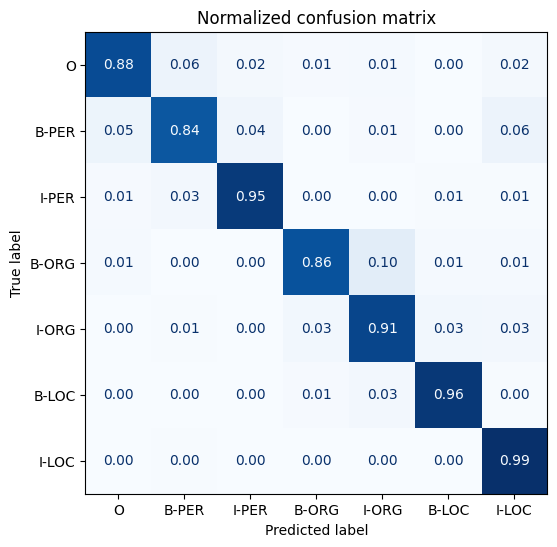

In [99]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [100]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [],[],[],[]
    for i, mask in enumerate(row["attention_mask"]):
      if(i not in {0, len(row["attention_mask"])}):
        labels.append(row["labels"][i])
        preds.append(row["predicted_label"][i])
        tokens.append(row["input_tokens"][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"tokens":tokens, "labels":labels,
                           "preds":preds,"losses":losses}).T
    yield df_tmp

In [101]:
df["total_loss"] = df["loss"].apply(sum)

In [102]:
df_tmp = df.sort_values(by="total_loss", ascending = False).head(3)

In [103]:
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,5.78,0.00,0.00,0.00,10.44,10.45,9.96,9.71,10.32,0.00,9.86,10.26,0.00,10.03,10.21,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,9.07,0.00,0.00,8.97,9.15,9.48,6.94,0.00,7.85,9.48,7.72,7.53,5.88,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.99,6.24,6.07,0.00,6.03,0.00,5.76,0.00,5.81,5.64,5.80,6.07,6.15,6.09,0.00


In [104]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


In [106]:
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

In [107]:
f1_scores = defaultdict(dict)

In [108]:
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])

In [109]:
print(f"F1-score of [de] model on [de] dataset : {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset : 0.866


In [110]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [111]:
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds["test"])

In [112]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr",trainer)
print(f"F1-score of [de] model on [fr] dataset : {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

F1-score of [de] model on [fr] dataset : 0.702


In [113]:
f1_scores["de"]["it"] = evaluate_lang_performance("it",trainer)
print(f"F1-score of [de] model on [it] dataset : {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

F1-score of [de] model on [it] dataset : 0.688


In [114]:
f1_scores["de"]["en"] = evaluate_lang_performance("en",trainer)
print(f"F1-score of [de] model on [en] dataset : {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

F1-score of [de] model on [en] dataset : 0.582


In [115]:
def train_on_subset(dataset, num_samples):
  train_ds = dataset["train"].shuffle(seed = 42).select(range(num_samples))
  valid_ds = dataset["validation"]
  test_ds = dataset["test"]
  training_args.logging_steps = len(train_ds)//batch_size

  trainer = Trainer(model_init = model_init, args = training_args, data_collator = data_collator,
                    compute_metrics = compute_metrics, train_dataset = train_ds, eval_dataset = valid_ds, tokenizer = xlmr_tokenizer)
  trainer.train()
  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message = "Training Completed!")
  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict(
      {"num_samples":[len(train_ds)], "f1_score":[f1_score]}
  )

In [116]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [117]:
training_args.push_to_hub = False

In [118]:
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.611400,1.290540,0.023221
2,1.186100,0.994059,0.194721
3,0.996400,0.918272,0.258691


,num_samples,f1_score
0,250,0.260191


In [123]:
for num_samples in [500,1000,2000,4000]:
  metrics_df = pd.concat([metrics_df,
      train_on_subset(panx_fr_encoded, num_samples)], ignore_index = True
  )

Epoch,Training Loss,Validation Loss,F1
1,1.424700,1.023299,0.273481
2,0.868600,0.658805,0.558438
3,0.594300,0.569413,0.631595


Epoch,Training Loss,Validation Loss,F1
1,1.070700,0.547355,0.668593
2,0.452200,0.419030,0.719858
3,0.301100,0.392787,0.765788


Epoch,Training Loss,Validation Loss,F1
1,0.774600,0.424113,0.729323
2,0.321700,0.343038,0.776030
3,0.204100,0.331930,0.813378


Epoch,Training Loss,Validation Loss,F1
1,0.587900,0.336302,0.785022
2,0.274500,0.305499,0.821070
3,0.178800,0.284760,0.833779


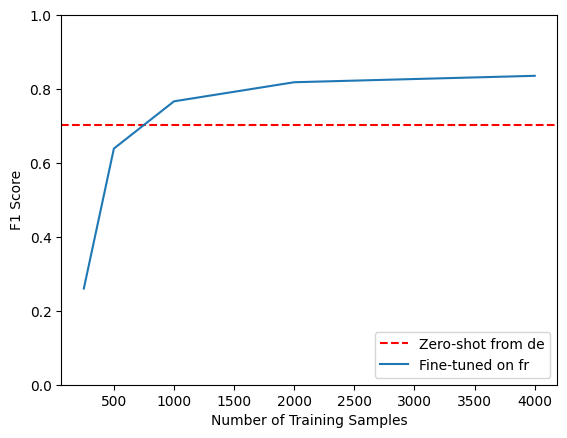

In [125]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [124]:
from datasets import concatenate_datasets

In [126]:
def concatenate_splits(corpora):
  multi_corpus = DatasetDict()
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora].shuffle(seed= 42))
  return multi_corpus